The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install --no-deps git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

# 注意力提示
:label:`sec_attention-cues`

感谢读者对本书的关注，因为读者的注意力是一种稀缺的资源：
此刻读者正在阅读本书（而忽略了其他的书），
因此读者的注意力是用机会成本（与金钱类似）来支付的。
为了确保读者现在投入的注意力是值得的，
作者们尽全力（全部的注意力）创作一本好书。

自经济学研究稀缺资源分配以来，人们正处在“注意力经济”时代，
即人类的注意力被视为可以交换的、有限的、有价值的且稀缺的商品。
许多商业模式也被开发出来去利用这一点：
在音乐或视频流媒体服务上，人们要么消耗注意力在广告上，要么付钱来隐藏广告；
为了在网络游戏世界的成长，人们要么消耗注意力在游戏战斗中，
从而帮助吸引新的玩家，要么付钱立即变得强大。
总之，注意力不是免费的。

注意力是稀缺的，而环境中的干扰注意力的信息却并不少。
比如人类的视觉神经系统大约每秒收到$10^8$位的信息，
这远远超过了大脑能够完全处理的水平。
幸运的是，人类的祖先已经从经验（也称为数据）中认识到
“并非感官的所有输入都是一样的”。
在整个人类历史中，这种只将注意力引向感兴趣的一小部分信息的能力，
使人类的大脑能够更明智地分配资源来生存、成长和社交，
例如发现天敌、找寻食物和伴侣。

## 生物学中的注意力提示

注意力是如何应用于视觉世界中的呢？
这要从当今十分普及的*双组件*（two-component）的框架开始讲起：
这个框架的出现可以追溯到19世纪90年代的威廉·詹姆斯，
他被认为是“美国心理学之父” :cite:`James.2007`。
在这个框架中，受试者基于*非自主性提示*和*自主性提示*
有选择地引导注意力的焦点。

非自主性提示是基于环境中物体的突出性和易见性。
想象一下，假如我们面前有五个物品：
一份报纸、一篇研究论文、一杯咖啡、一本笔记本和一本书，
就像 :numref:`fig_eye-coffee`。
所有纸制品都是黑白印刷的，但咖啡杯是红色的。
换句话说，这个咖啡杯在这种视觉环境中是突出和显眼的，
不由自主地引起人们的注意。
所以我们会把视力最敏锐的地方放到咖啡上，
如 :numref:`fig_eye-coffee`所示。

![由于突出性的非自主性提示（红杯子），注意力不自主地指向了咖啡杯](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/eye-coffee.svg?raw=1)
:width:`400px`
:label:`fig_eye-coffee`

喝咖啡后，我们会变得兴奋并想读书，
所以转过头，重新聚焦眼睛，然后看看书，
就像 :numref:`fig_eye-book`中描述那样。
与 :numref:`fig_eye-coffee`中由于突出性导致的选择不同，
此时选择书是受到了认知和意识的控制，
因此注意力在基于自主性提示去辅助选择时将更为谨慎。
受试者的主观意愿推动，选择的力量也就更强大。

![依赖于任务的意志提示（想读一本书），注意力被自主引导到书上](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/eye-book.svg?raw=1)
:width:`400px`
:label:`fig_eye-book`

## 查询、键和值

自主性的与非自主性的注意力提示解释了人类的注意力的方式，
下面来看看如何通过这两种注意力提示，
用神经网络来设计注意力机制的框架，

首先，考虑一个相对简单的状况，
即只使用非自主性提示。
要想将选择偏向于感官输入，
则可以简单地使用参数化的全连接层，
甚至是非参数化的最大汇聚层或平均汇聚层。

因此，“是否包含自主性提示”将注意力机制与全连接层或汇聚层区别开来。
在注意力机制的背景下，自主性提示被称为*查询*（query）。
给定任何查询，注意力机制通过*注意力汇聚*（attention pooling）
将选择引导至*感官输入*（sensory inputs，例如中间特征表示）。
在注意力机制中，这些感官输入被称为*值*（value）。
更通俗的解释，每个值都与一个*键*（key）配对，
这可以想象为感官输入的非自主提示。
如 :numref:`fig_qkv`所示，可以通过设计注意力汇聚的方式，
便于给定的查询（自主性提示）与键（非自主性提示）进行匹配，
这将引导得出最匹配的值（感官输入）。

![注意力机制通过注意力汇聚将*查询*（自主性提示）和*键*（非自主性提示）结合在一起，实现对*值*（感官输入）的选择倾向](http://d2l.ai/_images/qkv.svg)
:label:`fig_qkv`

鉴于上面所提框架在 :numref:`fig_qkv`中的主导地位，
因此这个框架下的模型将成为本章的中心。
然而，注意力机制的设计有许多替代方案。
例如可以设计一个不可微的注意力模型，
该模型可以使用强化学习方法 :cite:`Mnih.Heess.Graves.ea.2014`进行训练。

## 注意力的可视化

平均汇聚层可以被视为输入的加权平均值，
其中各输入的权重是一样的。
实际上，注意力汇聚得到的是加权平均的总和值，
其中权重是在给定的查询和不同的键之间计算得出的。


In [2]:
import torch
from d2l import torch as d2l

为了可视化注意力权重，需要定义一个`show_heatmaps`函数。
其输入`matrices`的形状是
（要显示的行数，要显示的列数，查询的数目，键的数目）。


In [3]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]  #num_rows：query的个数, num_cols:value的个数
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)  # query×value的个数
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

下面使用一个简单的例子进行演示。
在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。


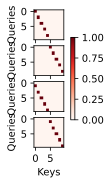

In [7]:
attention_weights = torch.eye(20).reshape((4, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

后面的章节内容将经常调用`show_heatmaps`函数来显示注意力权重。

## 小结

* 人类的注意力是有限的、有价值和稀缺的资源。
* 受试者使用非自主性和自主性提示有选择性地引导注意力。前者基于突出性，后者则依赖于意识。
* 注意力机制与全连接层或者汇聚层的区别源于增加的自主提示。
* 由于包含了自主性提示，注意力机制与全连接的层或汇聚层不同。
* 注意力机制通过注意力汇聚使选择偏向于值（感官输入），其中包含查询（自主性提示）和键（非自主性提示）。键和值是成对的。
* 可视化查询和键之间的注意力权重是可行的。

## 练习

1. 在机器翻译中通过解码序列词元时，其自主性提示可能是什么？非自主性提示和感官输入又是什么？
1. 随机生成一个$10 \times 10$矩阵并使用`softmax`运算来确保每行都是有效的概率分布，然后可视化输出注意力权重。


[Discussions](https://discuss.d2l.ai/t/5764)
